Device: cpu
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Split sizes -> Train: 40000 | Val: 5000 | Test: 5000
SimpleCIFAR10CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.15, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): B

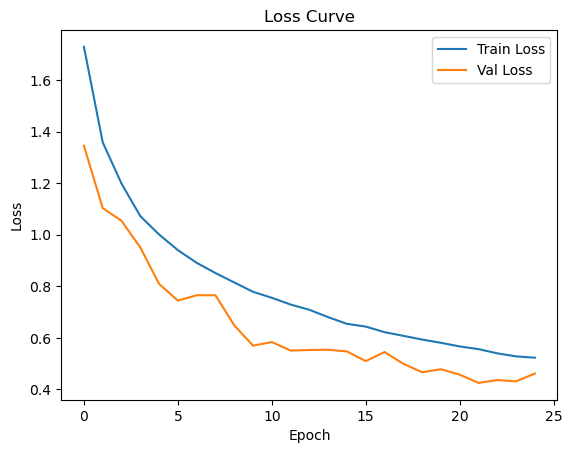

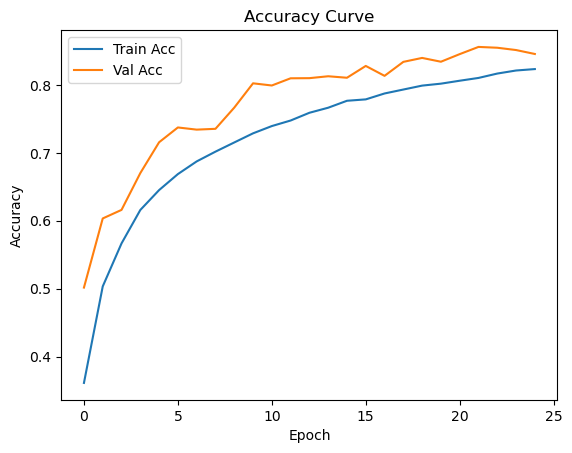

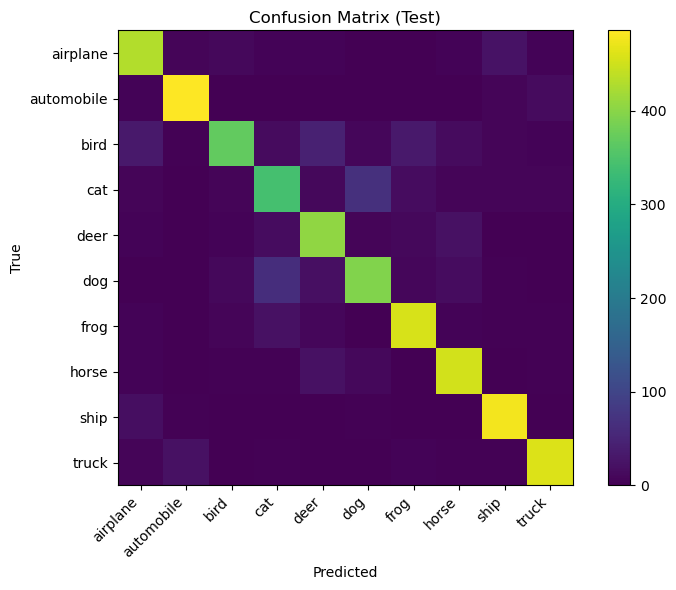

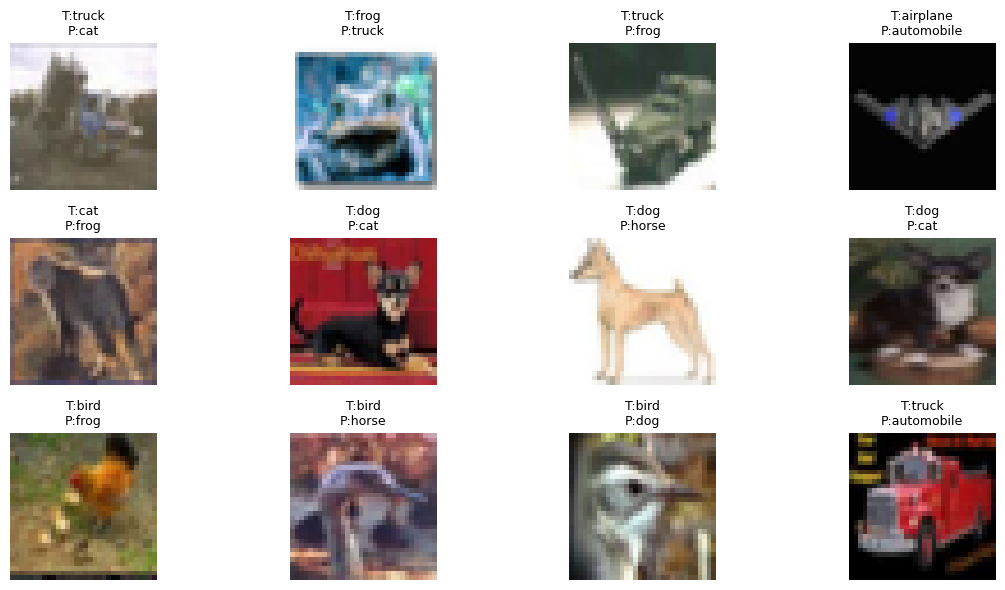

In [1]:
# Capstone Image Classification (PyTorch) - CIFAR-10
# - Train/Val/Test split
# - Data augmentation
# - CNN model (BatchNorm + Dropout)
# - Early stopping + best-model saving
# - Metrics: Accuracy, Precision, Recall, F1
# - Confusion matrix + sample misclassifications visualization

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 1) Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# 2) Config
DATA_DIR = "./data"
BATCH_SIZE = 128
EPOCHS = 25
LR = 1e-3
WEIGHT_DECAY = 1e-4
VAL_RATIO = 0.1
TEST_RATIO = 0.1
PATIENCE = 5                 # Early stopping patience
NUM_WORKERS = 2
PIN_MEMORY = True if device.type == "cuda" else False

# Optional: use subset to speed up (e.g., 20000 train samples)
USE_SUBSET = False
SUBSET_TRAIN_SIZE = 20000

# 3) Transforms (Augmentation + Normalization)
# CIFAR-10 mean/std (commonly used)
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std  = (0.2470, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

# 4) Dataset + Train/Val/Test Split
# Load full CIFAR-10 training set, then split into train/val/test
full_train = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)

# We will create val/test from this "train" split
n_total = len(full_train)
n_test = int(TEST_RATIO * n_total)
n_val = int(VAL_RATIO * n_total)
n_train = n_total - n_val - n_test
train_ds, val_ds, test_ds = random_split(full_train, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42))

# IMPORTANT: val/test should NOT use augmentation -> swap their transform
# random_split returns Subset objects pointing to full_train. We can create
# new Subsets wrapping the same indices but with a dataset that uses test_transform.
base_no_aug = datasets.CIFAR10(root=DATA_DIR, train=True, download=False, transform=test_transform)
val_ds = Subset(base_no_aug, val_ds.indices)
test_ds = Subset(base_no_aug, test_ds.indices)

if USE_SUBSET:
    # Take a smaller subset from train_ds
    subset_indices = train_ds.indices[:SUBSET_TRAIN_SIZE]
    train_ds = Subset(full_train, subset_indices)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# Class names
classes = datasets.CIFAR10(root=DATA_DIR, train=False, download=True).classes
num_classes = len(classes)
print("Classes:", classes)
print(f"Split sizes -> Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

# 5) Model (CNN)
class SimpleCIFAR10CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1: 32x32
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2),   # 16x16
            nn.Dropout(0.15),

            # Block 2: 16x16
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2),   # 8x8
            nn.Dropout(0.20),

            # Block 3: 8x8
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2),   # 4x4
            nn.Dropout(0.25),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.35),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = SimpleCIFAR10CNN(num_classes=num_classes).to(device)
print(model)

# 6) Metrics Helpers (no sklearn needed)
@torch.no_grad()
def compute_confusion_matrix(y_true, y_pred, num_classes):
    cm = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

def precision_recall_f1_from_cm(cm):
    # cm: [C, C], rows=true, cols=pred
    tp = torch.diag(cm).float()
    fp = cm.sum(dim=0).float() - tp
    fn = cm.sum(dim=1).float() - tp

    precision = tp / (tp + fp + 1e-12)
    recall = tp / (tp + fn + 1e-12)
    f1 = 2 * precision * recall / (precision + recall + 1e-12)

    # macro averages
    return precision.mean().item(), recall.mean().item(), f1.mean().item()

# 7) Train / Eval Loops
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_true = []
    all_pred = []

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_true.append(labels.detach().cpu())
        all_pred.append(preds.detach().cpu())

    all_true = torch.cat(all_true)
    all_pred = torch.cat(all_pred)

    cm = compute_confusion_matrix(all_true, all_pred, num_classes)
    prec, rec, f1 = precision_recall_f1_from_cm(cm)

    return (running_loss / total), (correct / total), prec, rec, f1, cm, all_true, all_pred

# 8) Early Stopping
best_val_acc = 0.0
best_path = "best_cifar10_cnn.pt"
patience_counter = 0

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

history = {
    "train_loss": [], "train_acc": [],
    "val_loss": [], "val_acc": [],
}

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    va_loss, va_acc, va_prec, va_rec, va_f1, va_cm, _, _ = evaluate(model, val_loader, criterion)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | "
          f"Val Loss: {va_loss:.4f} Acc: {va_acc:.4f} | "
          f"Val P/R/F1: {va_prec:.4f}/{va_rec:.4f}/{va_f1:.4f}")

    # Early stopping on validation accuracy
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), best_path)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping triggered. Best Val Acc: {best_val_acc:.4f}")
            break

# Load best model
model.load_state_dict(torch.load(best_path, map_location=device))

# 9) Final Test Evaluation
test_loss, test_acc, test_prec, test_rec, test_f1, test_cm, y_true, y_pred = evaluate(model, test_loader, criterion)

print("\n=== TEST RESULTS (Best Model) ===")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision (macro): {test_prec:.4f}")
print(f"Recall (macro): {test_rec:.4f}")
print(f"F1-score (macro): {test_f1:.4f}")

# 10) Plots: Loss & Accuracy Curves
plt.figure()
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

plt.figure()
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.show()

# 11) Confusion Matrix Plot
plt.figure(figsize=(8, 6))
plt.imshow(test_cm.numpy(), interpolation="nearest")
plt.title("Confusion Matrix (Test)")
plt.colorbar()
plt.xticks(ticks=np.arange(num_classes), labels=classes, rotation=45, ha="right")
plt.yticks(ticks=np.arange(num_classes), labels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# 12) Visualize Misclassifications 
@torch.no_grad()
def show_misclassifications(model, dataset, y_true, y_pred, max_images=12):
    # Find misclassified indices
    wrong = (y_true != y_pred).nonzero(as_tuple=False).squeeze(1).tolist()
    if len(wrong) == 0:
        print("No misclassifications found!")
        return

    n_show = min(max_images, len(wrong))
    pick = wrong[:n_show]

    # Need unnormalized images for display
    unnorm = transforms.Normalize(
        mean=[-m/s for m, s in zip(cifar10_mean, cifar10_std)],
        std=[1/s for s in cifar10_std]
    )

    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(pick):
        img, _ = dataset[idx]  # this is normalized
        img_disp = unnorm(img).clamp(0, 1)

        plt.subplot(3, 4, i + 1)
        plt.imshow(img_disp.permute(1, 2, 0).cpu().numpy())
        plt.title(f"T:{classes[y_true[idx]]}\nP:{classes[y_pred[idx]]}", fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Use test_ds (no augmentation) for correct visuals
show_misclassifications(model, test_ds, y_true, y_pred, max_images=12)
